# dp_ml package testing

This notebook goes through a few examples with the dp_ml package:

1. Import packages and data
2. Show some examples of the data and processing methods
3. Set up the learning method
4. Train the model
5. Predict using testing data

## 1. Import packages and data:

In [1]:
import dp_ml
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema
import pywt
import seaborn
from statsmodels.robust import mad
import tensorflow as tf
from ipywidgets.widgets import interactive, interact
import ipywidgets as widgets
from tabulate import tabulate

%matplotlib inline

/Users/davidgarrett/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Macintosh detected, data path found


In [2]:
#dbFile = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5')
dbFile = h5py.File('/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5')
dbHier = 'Data/Simulation/CircWG'

## 2. Show examples of the data and processing methods

In [3]:
X_batch_test_f , y_batch_test_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 385, freqOrTime='frequency', procFx = dp_ml.procIdentity)

In [18]:
print(X_batch_test_f[0,1,:10])

[  2.00000000e+09   2.00200000e+09   2.00400000e+09   2.00600000e+09
   2.00800000e+09   2.01000000e+09   2.01200000e+09   2.01400000e+09
   2.01600000e+09   2.01800000e+09]


In [4]:
X_batch_t , y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 10, freqOrTime='time')

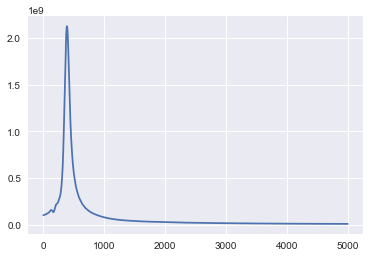

In [5]:
plt.plot(X_batch_t[5,2,:])

In [4]:
X_batch_max , y_batch_max = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1362, freqOrTime='time', procFx = dp_ml.getMaxAndEnergy)

In [5]:
print(X_batch_max.shape)
print(X_batch_max[0,0,:])

(1362, 5, 2)
[ 1.  1.]


(31, 5, 2)


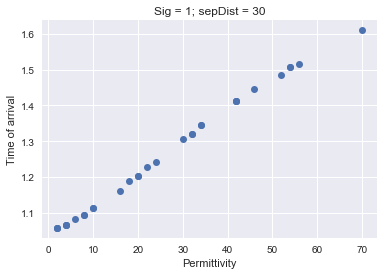

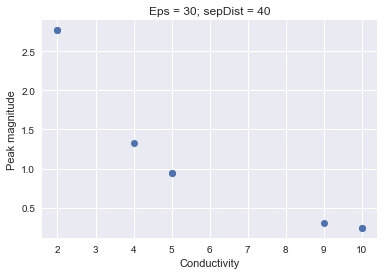

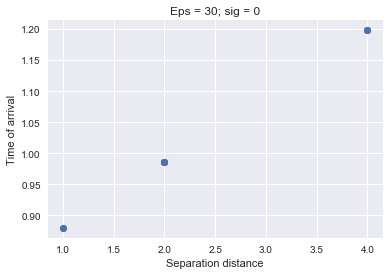

In [6]:
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, sig = 8, sepDist = 3)
print(X_filt.shape)
plt.plot(y_filt[:,0], X_filt[:,2,1],'o')
plt.title('Sig = 1; sepDist = 30')
plt.xlabel('Permittivity')
plt.ylabel('Time of arrival')

X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=20, sepDist = 1)
plt.figure()
plt.plot(y_filt[:,1], X_filt[:,2,0],'o')
plt.title('Eps = 30; sepDist = 40')
plt.xlabel('Conductivity')
plt.ylabel('Peak magnitude')

plt.figure()
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=10, sig = 1)
plt.plot(X_filt[:,0,0], X_filt[:,2,1],'o')
plt.title('Eps = 30; sig = 0')
plt.xlabel('Separation distance')
plt.ylabel('Time of arrival')

In [9]:
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=30, sig = 1)
print(X_filt[1,0,0])

2.0


### 2.1 Feature expansion:

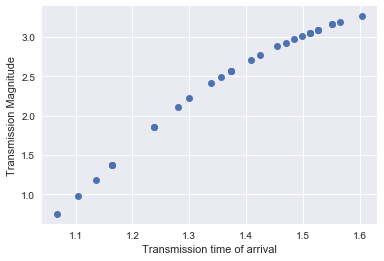

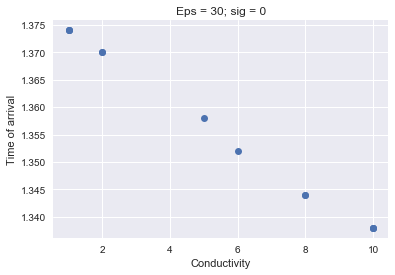

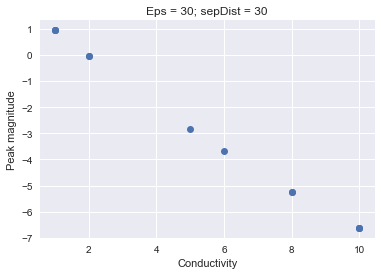

In [10]:
sig = 1


X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, sig = sig, sepDist = 3)

plt.figure()
plt.plot((X_filt[:,2,1]),X_filt[:,2,0],'o')
plt.xlabel('Transmission time of arrival')
plt.ylabel('Transmission Magnitude')


eps = 34


plt.figure()
X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=eps, sepDist = 3)
plt.plot(y_filt[:,1], X_filt[:,2,1],'o')
plt.title('Eps = 30; sig = 0')
plt.xlabel('Conductivity')
plt.ylabel('Time of arrival')

X_filt, y_filt = dp_ml.filterData(X_batch_max, y_batch_max, eps=eps, sepDist = 3)
plt.figure()
plt.plot(y_filt[:,1], np.log(X_filt[:,2,0]),'o')
plt.title('Eps = 30; sepDist = 30')
plt.xlabel('Conductivity')
plt.ylabel('Peak magnitude')

(16, 10, 5000)


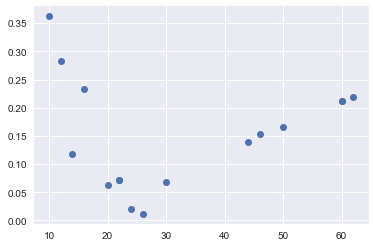

In [11]:
X_filt, y_filt = dp_ml.filterData(X_batch_test_f, y_batch_test_f, sig = 0, sepDist = 3)

print(X_filt.shape)
plt.plot(y_filt[:,0],X_filt[:,2,2500],'o')

In [19]:
X_batch_t, y_batch_t = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='time', procFx = dp_ml.procIdentity)
X_batch_f, y_batch_f = dp_ml.getBatchFromDB(dbFile, dbHier, 0, 1350, freqOrTime='frequency', procFx = dp_ml.procIdentity)

In [13]:
print(X_batch_max.shape)
print(X_batch_max[1000,:,:])

(1362, 5, 2)
[[ 2.          2.        ]
 [ 2.01909619  0.794     ]
 [ 0.45032793  0.956     ]
 [ 0.17924483  0.        ]
 [ 0.77120792  0.        ]]


## 3. Set up the learning method

### 3.1 Setting it up for getMax():

In [7]:
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 =10,n_hidden2=3, batch_size=15, activation_function = tf.nn.sigmoid)
#init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,n_hidden1 =30,n_hidden2=10, batch_size=100, activation_function = tf.nn.sigmoid)
init, saver, loss, training_op, X_ph, y, logits = dp_ml.setupModel(n_inputs = 10,
                        n_hidden1 =200,n_hidden2=100, batch_size=100, 
                        activation_function = tf.nn.relu,opt="gradient", # was adam
                        learning_rate = 0.0005) # changed from 0.01 (10 May 2018)

## 4. Train the model

In [ ]:
#dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_07-Feb-2018.hdf5'
#dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5'
dbFilename = '/Users/davidgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_11-Mar-2018.hdf5'


dbFolder = 'Data/Simulation/CircWG'
model_name = dp_ml.runModel(dbFilename, dbFolder, init, saver, loss, training_op, X_ph, y, procFx = dp_ml.getMaxAndEnergy, freqOrTime = 'time',batch_size = 100, n_epochs = 10000)

Model filename:  ./Models/ANN_model_20180516-024608_10000-epochs_.ckpt
0 Train loss: 2.71568695068
1 Train loss: 2.07275756836
2 Train loss: 2.50597915649
3 Train loss: 2.1870552063
4 Train loss: 2.31017593384
5 Train loss: 1.46158035278
6 Train loss: 1.80058013916
7 Train loss: 2.00840744019
8 Train loss: 2.09531188965
9 Train loss: 2.46423568726
10 Train loss: 1.82018966675
11 Train loss: 2.05190689087
12 Train loss: 1.93530410767
13 Train loss: 2.21751968384
14 Train loss: 1.40526184082
15 Train loss: 1.48314178467
16 Train loss: 1.89883255005
17 Train loss: 1.32792999268
18 Train loss: 1.57326766968
19 Train loss: 1.39697021484
20 Train loss: 1.40110687256
21 Train loss: 1.33824752808
22 Train loss: 1.43486404419
23 Train loss: 0.999375991821
24 Train loss: 1.10139228821
25 Train loss: 1.17832832336
26 Train loss: 1.1678037262
27 Train loss: 1.03210006714
28 Train loss: 1.01255470276
29 Train loss: 1.1209564209
30 Train loss: 1.28022460938
31 Train loss: 0.830217895508
32 Train los

## 5. Predict from the model

In [11]:
np.set_printoptions(formatter={'float': lambda x: "{0:0.1f}".format(x)})

ind = np.arange(40,50)
X_batch = X_batch_max[ind,:,:].reshape((10,10))
y_pred = dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

# print separation distance too...
print(tabulate([['True eps: ', y_batch_max[ind,0]], ['Predicted eps: ', y_pred[:,0]], ['True sig: ',y_batch_max[ind,1]], ['Predicted sig: ', y_pred[:,1]]]))

INFO:tensorflow:Restoring parameters from ./Models/ANN_model_20180511-182150_10000-epochs_.ckpt
--------------  -------------------------------------------------
True eps:       [2.0 50.0 70.0 24.0 58.0 32.0 48.0 42.0 24.0 8.0]
Predicted eps:  [1.9 49.9 69.9 23.6 57.6 32.0 48.1 41.8 23.5 8.0]
True sig:       [5.0 1.0 9.0 1.0 4.0 8.0 10.0 0.0 0.0 8.0]
Predicted sig:  [5.1 1.0 9.1 1.0 4.0 8.0 10.1 -0.0 -0.1 7.8]
--------------  -------------------------------------------------


In [14]:
dbFile_test = h5py.File('C:/Users/dgarrett/Google Drive/Work/Software/machine_learning/postpro/dp_ml_test_data_11-May-2018.hdf5')
dbFolder_test = 'Data/Simulation/CircWG'

X_batch_test , y_batch_test = dp_ml.getBatchFromDB(dbFile_test, dbFolder_test, 0,18, freqOrTime='time', procFx = dp_ml.getMax)


In [15]:
X_batch = X_batch_test.reshape((18,10))
y_pred = dp_ml.predictFromModel(model_name, X_batch, saver, logits, X_ph)

# print separation distance too...
print(tabulate([['True eps: ', y_batch_test[:,0]], ['Predicted eps: ', y_pred[:,0]], ['True sig: ',y_batch_test[:,1]], ['Predicted sig: ', y_pred[:,1]], ['Separation dist: ', X_batch[:,0]]]))


INFO:tensorflow:Restoring parameters from ./Models/ANN_model_20180511-182150_10000-epochs_.ckpt
----------------  ---------------------------------------------------------------------------
True eps:         [66.2 31.4 66.2 31.4 31.4 66.2 66.2 31.4 31.4 66.2 66.2 66.2 66.2 31.4 31.4
                   66.2 66.2 31.4]
Predicted eps:    [58.3 31.7 63.1 29.1 31.6 61.5 63.9 31.6 31.6 61.7 63.9 61.7 61.7 29.7 33.2
                   61.5 61.7 30.2]
True sig:         [5.3 5.3 5.3 7.4 5.5 7.4 7.4 5.5 5.5 5.5 7.4 5.5 5.5 5.5 7.4 7.4 5.3 5.3]
Predicted sig:    [5.0 4.7 4.4 6.9 4.9 6.1 5.7 4.9 4.9 4.7 5.7 4.7 4.7 5.5 6.6 6.1 4.5 5.3]
Separation dist:  [1.4 1.7 2.9 1.4 1.7 1.7 2.9 1.7 1.7 1.7 2.9 1.7 1.7 1.4 2.9 1.7 1.7 1.4]
----------------  ---------------------------------------------------------------------------


In [10]:
print(model_name)

./Models/ANN_model_20180511-182150_10000-epochs_.ckpt


In [35]:
t = np.zeros((2,5,2))
print(t.shape)

t = t.reshape(2,10)
print(t.shape)

(2, 5, 2)
(2, 10)


## Scrap code:

In [ ]:
interact(plotMagPhase,eps=widgets.IntSlider(min=2,max=70,step=2,value=26),
         sig=widgets.IntSlider(min=0,max=10,step=1,value=2),sepDist=widgets.IntSlider(min=10,max=50,step=10,value=30), 
         scale=widgets.FloatSlider(min=0.1,max=5.0,step=0.1,value=1.0, absPlot=True), 
         mode=['transmission','reflection'], domain = ['time', 'frequency']);